<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/power_spectrum/assets/spectrum_power_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 120

# Univariate functions

In [43]:
import scipy.linalg as sla
import numpy as np

def univariate_spectral(A, B, k, xs):
  """Computes the vector y[i] = λₖ(A + B * xs[i])."""

  # support negative eigenvaue indices,
  #  e.g., k=-1 is the largest eigenvalue
  k = k % A.shape[0]

  # create a batch of matrices, one for each entry in xs
  mats = A + B * xs[..., np.newaxis, np.newaxis]

  # compute he k-th eigenvalue of each matrix
  return sla.eigvalsh(mats, subset_by_index=(k, k)).squeeze()

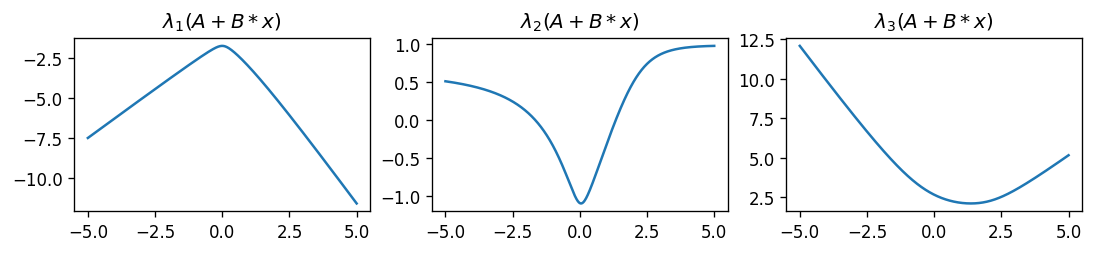

In [44]:
import matplotlib.pyplot as plt

def plot_eigenfunctions(A, B, n_rows, n_cols):
  """Plots y = λₖ(A + B * x) on a grid layout"""
  fig, axs = plt.subplots(
      n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows), layout='constrained'
  )
  plot_xs = np.linspace(-5, 5, 1000)
  k = A.shape[0]
  for k, ax in enumerate(axs.ravel()[:k]):
    ax.plot(plot_xs, univariate_spectral(A, B, k, plot_xs))
    ax.set_title(f'$\\lambda_{1 + k}(A + B * x)$')
  plt.show()


np.random.seed(42)
A = np.random.randn(3, 3)
B = np.random.randn(3, 3)
plot_eigenfunctions(A, B, 1, 3)

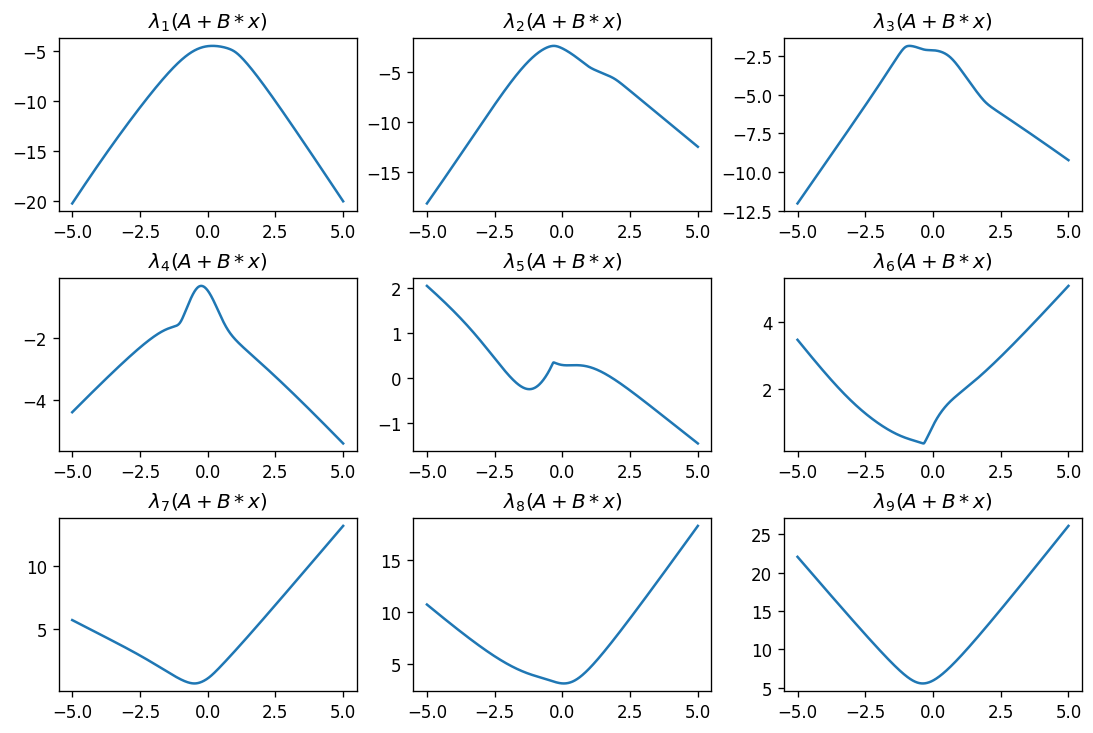

In [45]:
np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
plot_eigenfunctions(A, B, 3, 3)

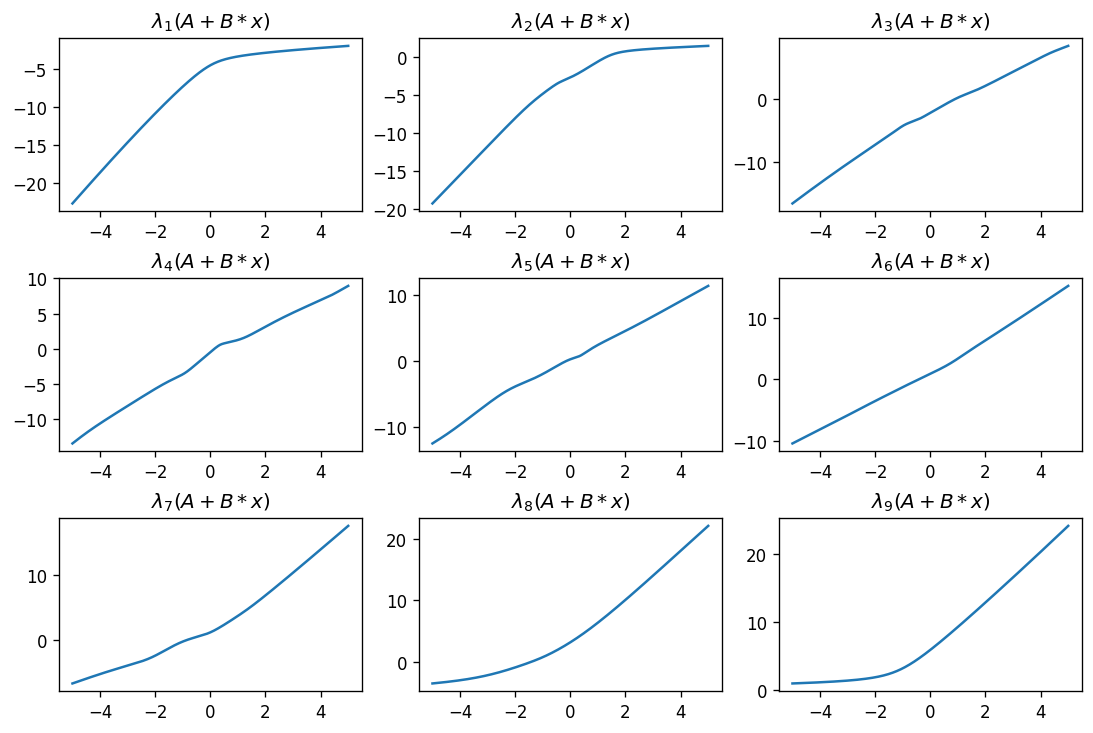

In [46]:
np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
plot_eigenfunctions(A, sla.sqrtm(B @ B.T), 3, 3)

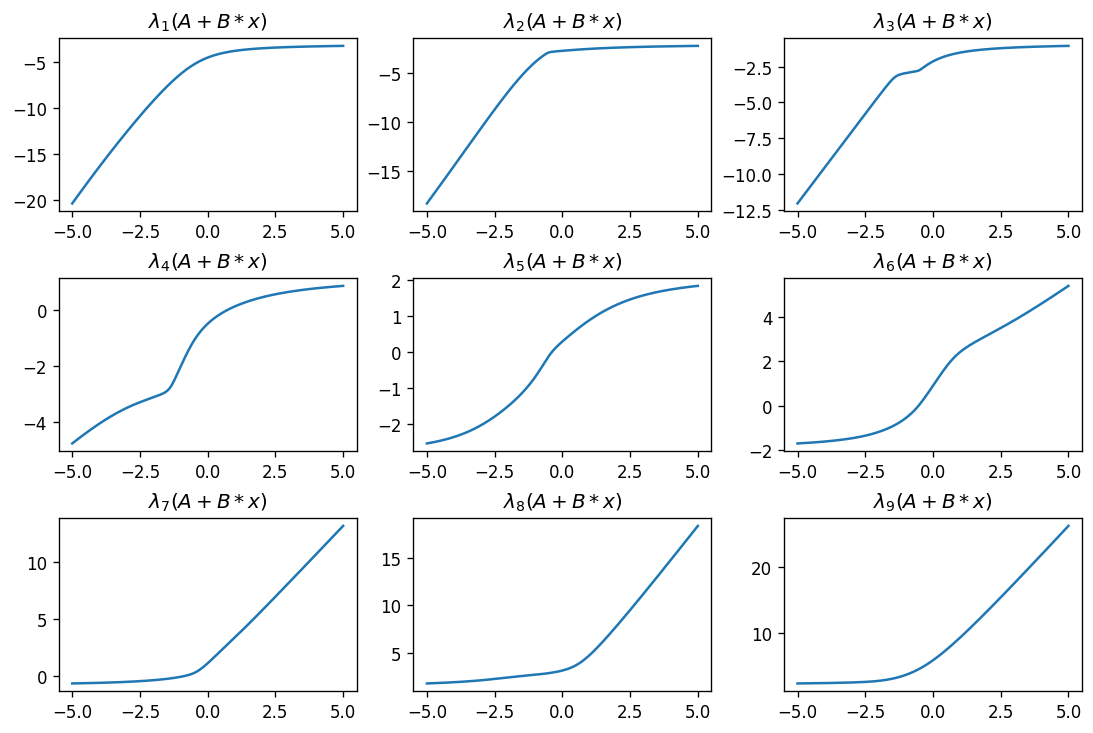

In [47]:
def make_psd(B):
  eigvals, eigvecs = sla.eigh(B)
  eigvals_pos = np.maximum(0, eigvals)
  return eigvecs @ np.diag(eigvals_pos) @ eigvecs.T

np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
plot_eigenfunctions(A, make_psd(B), 3, 3)

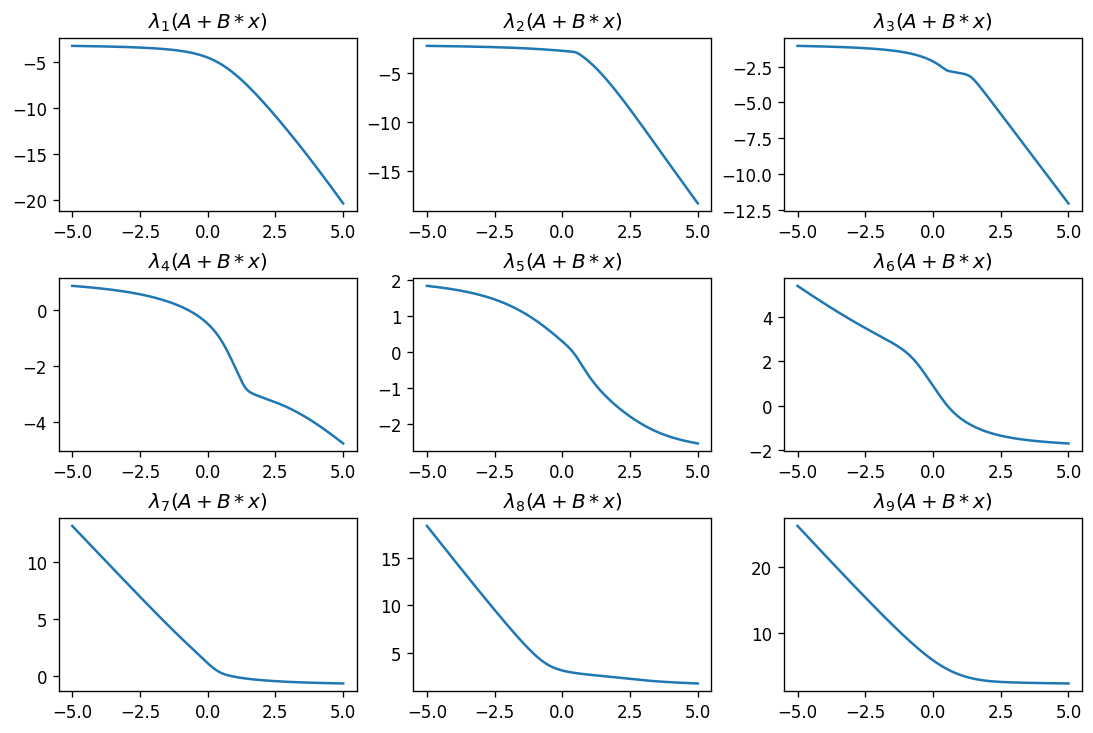

In [48]:
np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
plot_eigenfunctions(A, -make_psd(B), 3, 3)

# Bivariate functions

In [49]:
def bivariate_spectral(A, B, C, k, xs, ys):
  """Computes the vector z[i] = λₖ(A + B * xs[i] + C * ys[i])."""

  # support negative eigenvaue indices,
  #  e.g., k=-1 is the largest eigenvalue
  k = k % A.shape[0]

  # create a batch of matrices, one for each point (xs[i], ys[i])
  mats = (
      A + B * xs[..., np.newaxis, np.newaxis]
        + C * ys[..., np.newaxis, np.newaxis]
  )

  # compute he k-th eigenvalue of each matrix
  return sla.eigvalsh(mats, subset_by_index=(k, k)).squeeze()

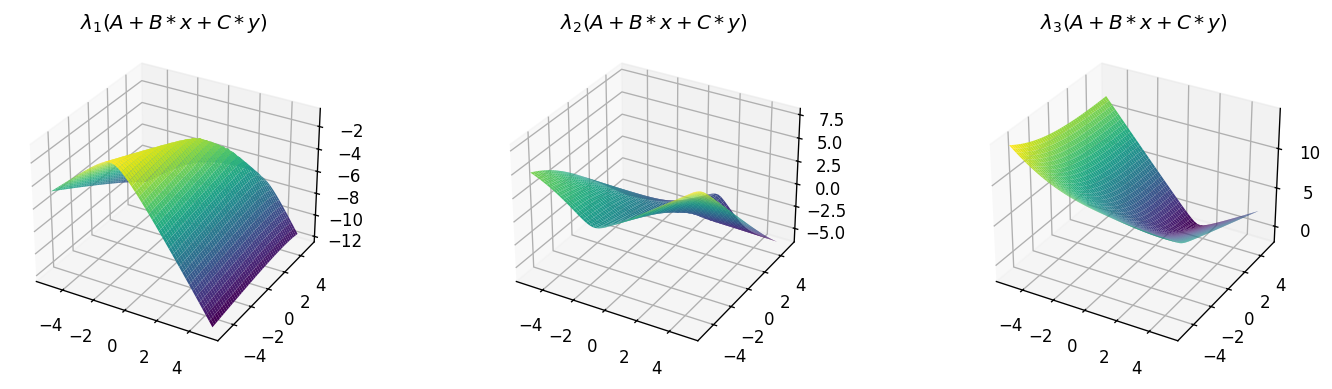

In [50]:
def plot_eigenfunctions_2d(A, B, C, n_rows, n_cols):
  """Plots z = λₖ(A + B * x + C * y) on a grid layout"""
  fig, axs = plt.subplots(
      n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows),
       subplot_kw={"projection": "3d"}, layout='constrained'
  )

  plot_xs = np.linspace(-5, 5, 50)
  grid_xs, grid_ys = np.meshgrid(plot_xs, plot_xs)

  k = A.shape[0]
  for k, ax in enumerate(axs.ravel()[:k]):
    grid_zs = bivariate_spectral(A, B, C, k, grid_xs, grid_ys)
    ax.plot_surface(grid_xs, grid_ys, grid_zs, cmap='viridis')
    ax.set_title(f'$\\lambda_{1 + k}(A + B * x + C * y)$')
  plt.show()


np.random.seed(42)
A = np.random.randn(3, 3)
B = np.random.randn(3, 3)
C = np.random.randn(3, 3)
plot_eigenfunctions_2d(A, B, C, 1, 3)

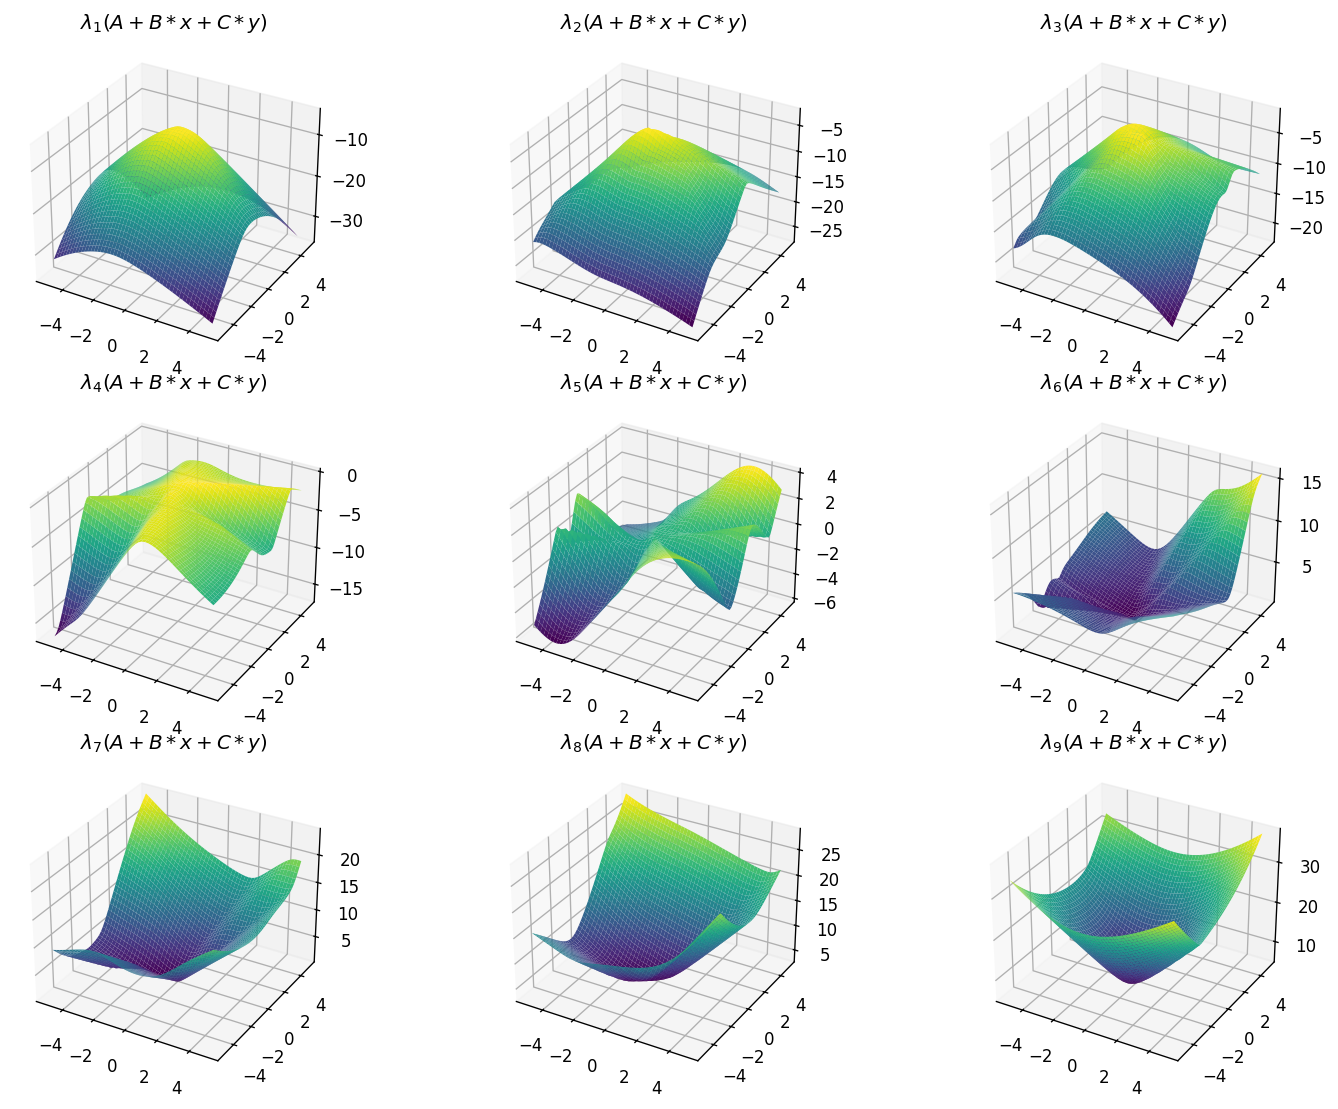

In [51]:
np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
C = np.random.randn(9, 9)
plot_eigenfunctions_2d(A, B, C, 3, 3)

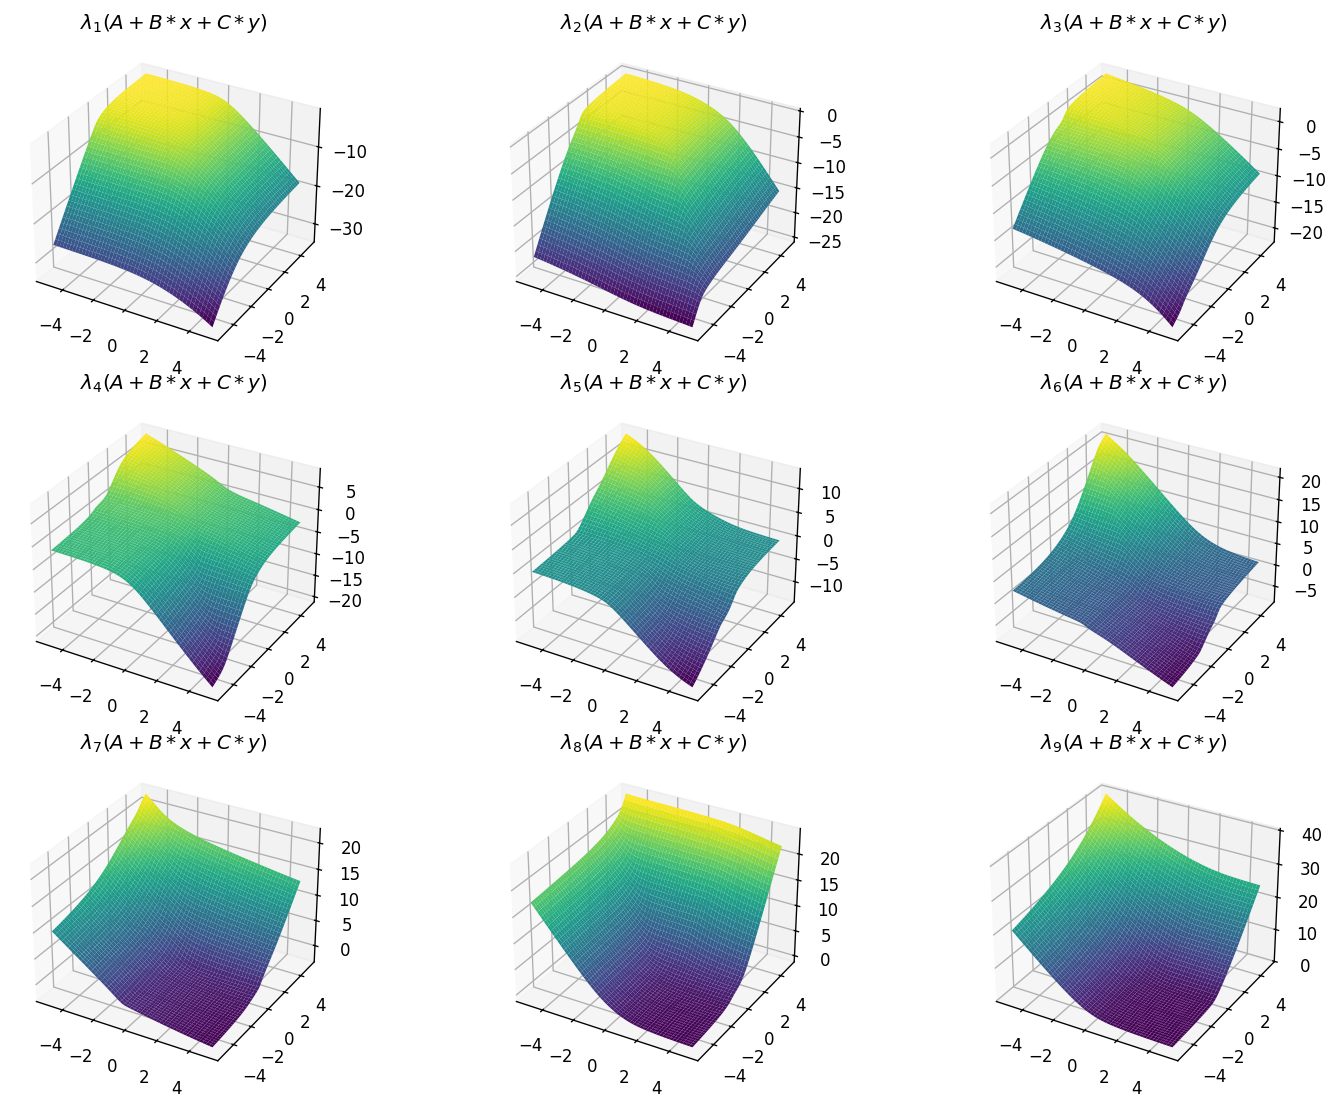

In [52]:
np.random.seed(42)
A = np.random.randn(9, 9)
B = np.random.randn(9, 9)
C = np.random.randn(9, 9)
plot_eigenfunctions_2d(A, -make_psd(B), make_psd(C), 3, 3)

# Fit concave function

In [53]:
def f(x, y):
    return -np.log(np.exp(x - 1) + np.exp(y + 0.5) + np.exp(0.5 - x - y))

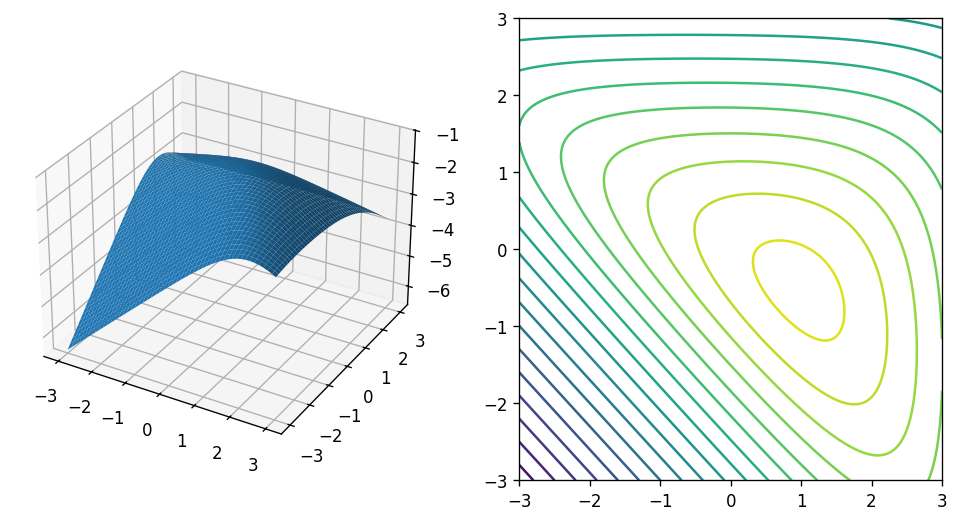

In [54]:
def plot_bivariate(X, Y, Z, show_rmse=False):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, Y, Z)
    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X, Y, Z, levels=20)
    if show_rmse:
        rmse = np.sqrt(np.mean(np.square(Z - f(X, Y))))
        fig.suptitle(f'RMSE = {rmse:.4f}')

x = np.linspace(-3, 3, 300)
y = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x, y)
plot_bivariate(X, Y, f(X, Y))

In [55]:
from torch.utils.data import TensorDataset
from torch import as_tensor

def make_trainset(n_train: int = 200, train_noise: float = 0.2):
    np.random.seed(42)
    x = np.random.uniform(-3, 3, n_train)
    y = np.random.uniform(-3, 3, n_train)
    z = f(x, y) + train_noise * np.random.randn(n_train)
    return x, y, z

x_train, y_train, z_train = make_trainset()
ds = TensorDataset(
    as_tensor(x_train), as_tensor(y_train), as_tensor(z_train)
)

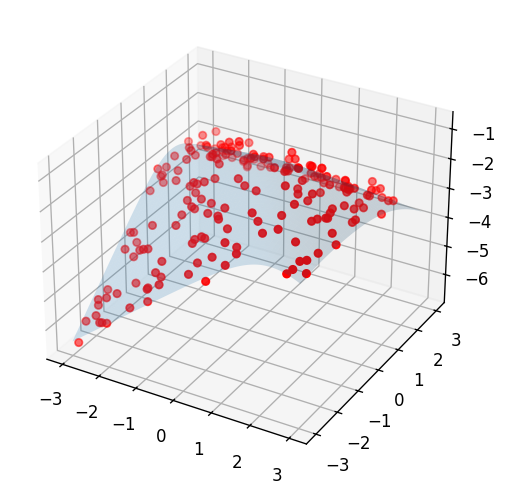

In [56]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x_train, y_train, z_train, color='red')
ax.plot_surface(X, Y, f(X, Y), alpha=0.2)

In [57]:
import torch
import torch.linalg as tla
from torch import nn

class BivariateSpectral(nn.Module):
    def __init__(self, *, dim: int, eigval_idx: int):
        super().__init__()
        self.eigval_idx = eigval_idx % dim  # modulo - to support negative idx
        self.A = nn.Parameter(torch.randn(dim, dim))
        self.B = nn.Parameter(torch.randn(dim, dim))
        self.C = nn.Parameter(torch.randn(dim, dim))

    def forward(self, x, y):
        # create a batch of matrices, one for each point (x[i], y[i])
        mats = (
            self.A + self.B * x[..., None, None] + self.C * y[..., None, None]
        )

        # compute the eigenvalues
        eigvals = tla.eigvalsh(mats)
        return eigvals[..., self.eigval_idx]

In [58]:
from torch.utils.data import DataLoader
import math
from tqdm.auto import tqdm, trange

def train_model(
        model: nn.Module, n_epochs: int = 500, batch_size = 5, lr=1e-3
    ):
    print_every = n_epochs // 10
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in trange(1, 1 + n_epochs):
        epoch_loss = 0.
        for x, y, z in dl:
            optimizer.zero_grad()
            loss = loss_fn(model(x, y), z)
            loss.backward()

            with torch.no_grad():
                epoch_loss += loss.item()
            optimizer.step()

        if epoch == n_epochs or epoch % print_every == 0:
            train_rmse = math.sqrt(epoch_loss / len(ds))
            tqdm.write(f'Epoch {epoch}, train RMSE: {train_rmse: .4f}')

    return model

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50, train RMSE:  0.1850
Epoch 100, train RMSE:  0.1334
Epoch 150, train RMSE:  0.1309
Epoch 200, train RMSE:  0.1253
Epoch 250, train RMSE:  0.1075
Epoch 300, train RMSE:  0.0940
Epoch 350, train RMSE:  0.0885
Epoch 400, train RMSE:  0.0869
Epoch 450, train RMSE:  0.0864
Epoch 500, train RMSE:  0.0860


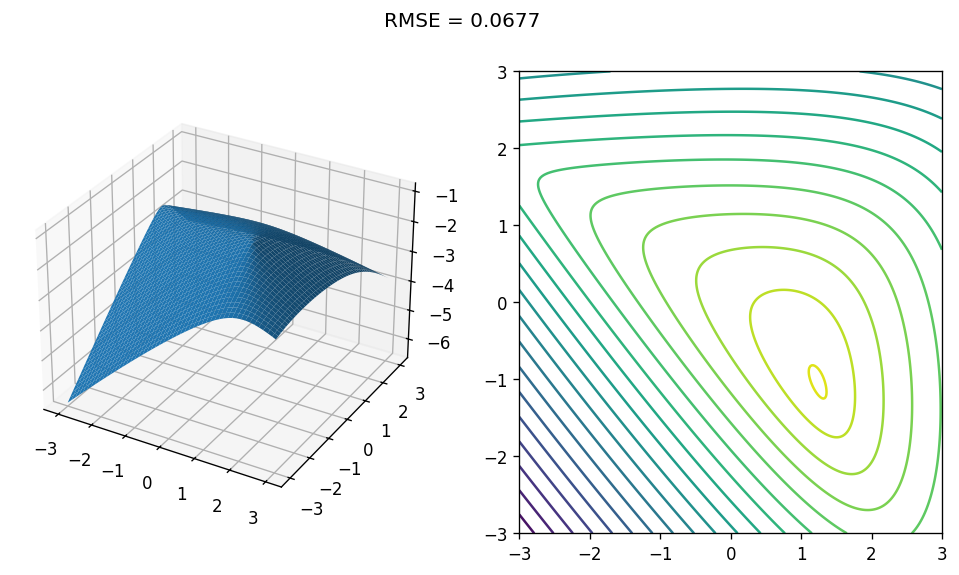

In [59]:
model = train_model(BivariateSpectral(dim=3, eigval_idx=0))
with torch.no_grad():
    Z = model(as_tensor(X), as_tensor(Y)).numpy()
plot_bivariate(X, Y, Z, show_rmse=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 200, train RMSE:  4.3918
Epoch 400, train RMSE:  2.2368
Epoch 600, train RMSE:  0.7924
Epoch 800, train RMSE:  0.1146
Epoch 1000, train RMSE:  0.0824
Epoch 1200, train RMSE:  0.0804
Epoch 1400, train RMSE:  0.0797
Epoch 1600, train RMSE:  0.0794
Epoch 1800, train RMSE:  0.0791
Epoch 2000, train RMSE:  0.0790


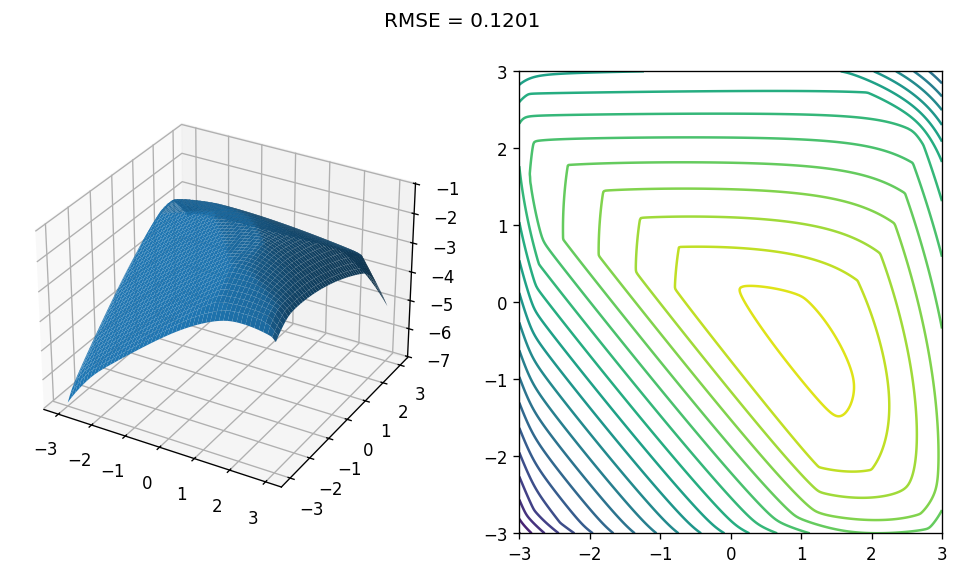

In [60]:
model = train_model(
    BivariateSpectral(dim=20, eigval_idx=0), n_epochs=2000, lr=1e-4
)
with torch.no_grad():
    Z = model(as_tensor(X), as_tensor(Y)).numpy()
plot_bivariate(X, Y, Z, show_rmse=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 200, train RMSE:  0.2391
Epoch 400, train RMSE:  0.1086
Epoch 600, train RMSE:  0.0916
Epoch 800, train RMSE:  0.0852
Epoch 1000, train RMSE:  0.0820
Epoch 1200, train RMSE:  0.0795
Epoch 1400, train RMSE:  0.0780
Epoch 1600, train RMSE:  0.0769
Epoch 1800, train RMSE:  0.0760
Epoch 2000, train RMSE:  0.0755


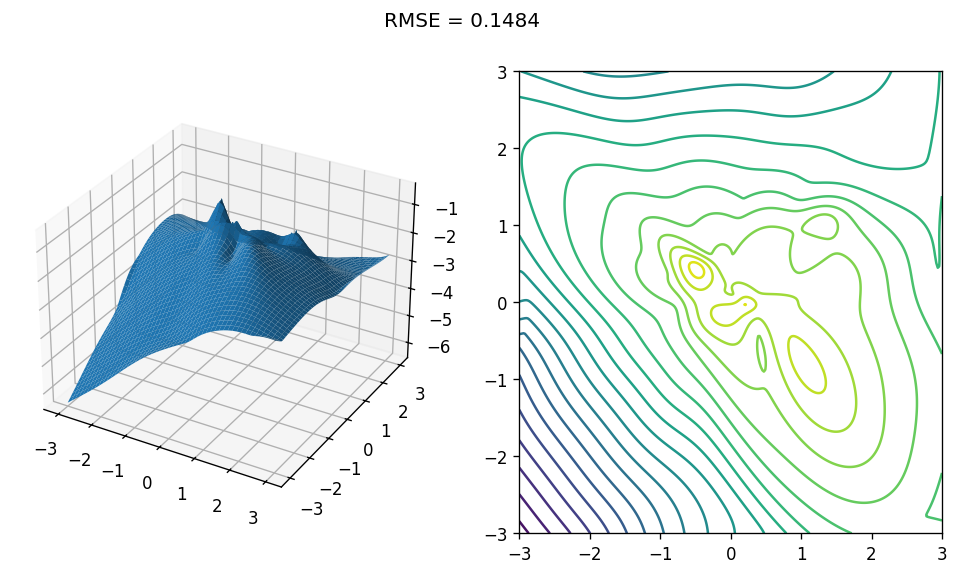

In [61]:
model = train_model(
    BivariateSpectral(dim=20, eigval_idx=10), n_epochs=2000, lr=1e-4
)
with torch.no_grad():
    Z = model(as_tensor(X), as_tensor(Y)).numpy()
plot_bivariate(X, Y, Z, show_rmse=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 200, train RMSE:  0.1124
Epoch 400, train RMSE:  0.0750
Epoch 600, train RMSE:  0.0712
Epoch 800, train RMSE:  0.0697
Epoch 1000, train RMSE:  0.0682
Epoch 1200, train RMSE:  0.0674
Epoch 1400, train RMSE:  0.0661
Epoch 1600, train RMSE:  0.0652
Epoch 1800, train RMSE:  0.0645
Epoch 2000, train RMSE:  0.0641


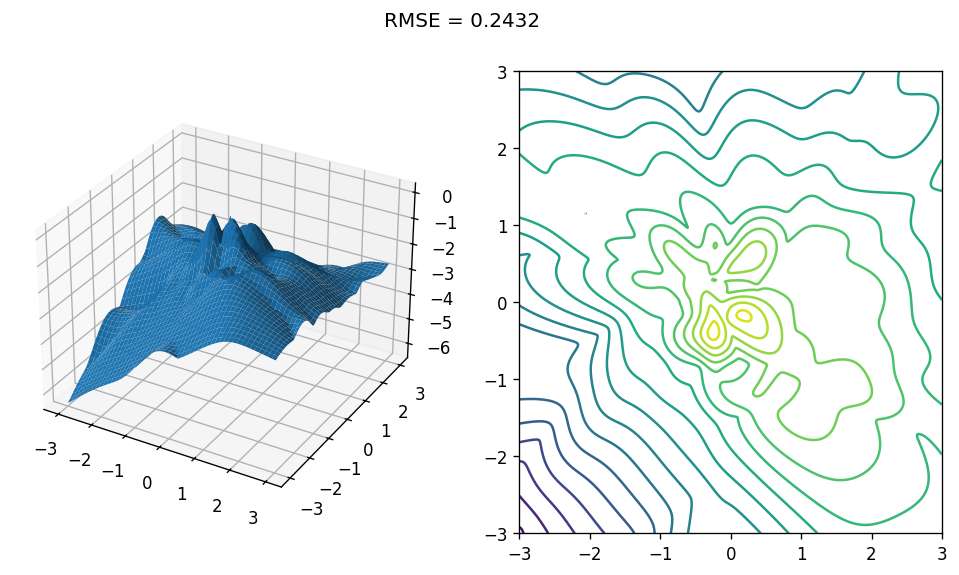

In [62]:
model = train_model(
    BivariateSpectral(dim=40, eigval_idx=20), n_epochs=2000, lr=1e-4
)
with torch.no_grad():
    Z = model(as_tensor(X), as_tensor(Y)).numpy()
plot_bivariate(X, Y, Z, show_rmse=True)